<a href="https://colab.research.google.com/github/natalia2000-jpg/Machine-learning/blob/main/%CE%95%CF%81%CE%B3%CE%B1%CF%83%CE%AF%CE%B1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Εργασία 4 – Ημι-επιβλεπόμενη Μάθηση & Αξιολόγηση Μοντέλων

όνομα:Ναταλία Ταμβακίδου ΑΕΜ:200

#Μέρος 1ο

#Εισαγωγή Βιβλιοθηκών

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import xgboost as xgb
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,BaggingRegressor,StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from itertools import product
from sklearn.model_selection import GridSearchCV
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,make_scorer

#Ερώτημα 1

In [ ]:
df=pd.read_csv("wine-missing.csv")
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,unknown,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,unknown,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,unknown,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6487.000000       6489.000000  6494.000000     6495.000000   
mean        7.216579          0.339691     0.318722        5.444326   
std         1.296750          0.164649     0.145265        4.758125   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6495.000000          6497.000000           6497.000000  6497.000000   
mean      0.056042            30.525319            115.744574     0.994697   
std       0.035036            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

Σχόλιο:
* Χαρακτηριστικά με μικρή τυπική απόκλιση όπως τα density και ph δεν θα έχουμ καθοριστικό ρόλο για την εκπέδευση του μοντέλου.
* Τα χαρακτηριστικά alcohol και sulphates πιθανότατα έχουν θετική συσχέτιση με το χαρακτιριστικό quality.

* Το χαρακτηριστικό free sulfur dioxide έχει mean περίπου στο 30.5 και μέγιστο 289,αυτό σημαίνει πιθανή παρουσία outliers.





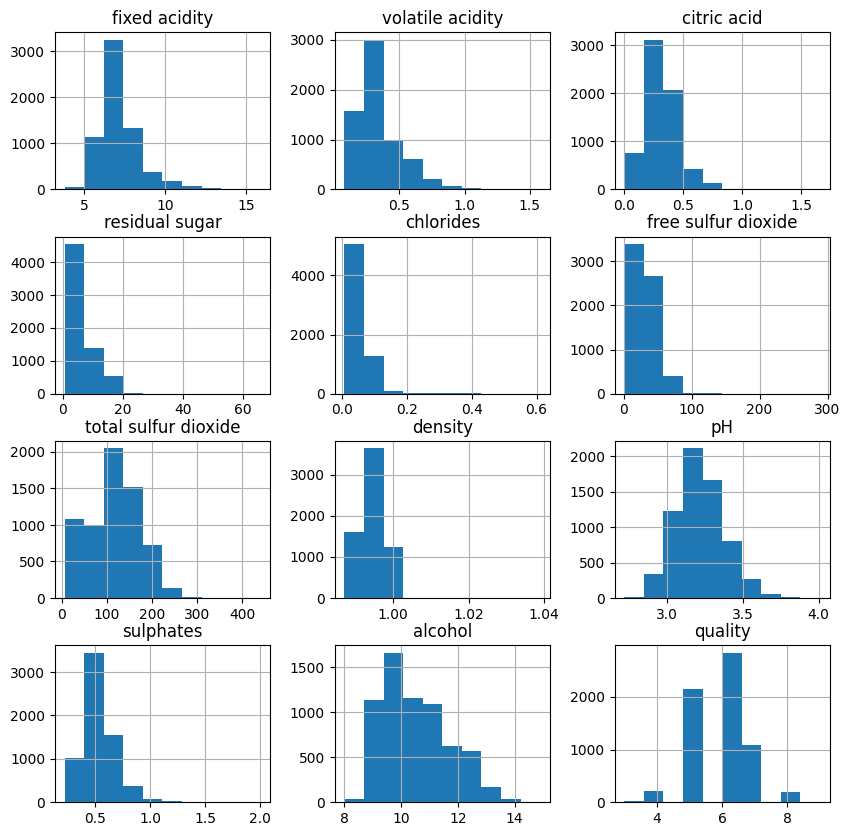

In [ ]:
selected_features=[]
for i in range(1,13):
  selected_features.append(df.columns[i])
df[selected_features].hist(figsize=(10, 10))
plt.show()

Σχόλιο:
*   Παρατηρούμε ότι στα περισσότερα ιστογράμματα των χαρακτηριστικών η πλειοψηφία των τιμών συγκεντρώνεται στην αριστερή πλευρά και υπάρχει μια μακριά ουρά που εκτείνεται στα δεξιά,δηλαδή οι μεταβλητές παρουσιάζουν δεξιά ασυμετρία.
* Όσον αφορά την μεταβλητηή quantity φαίνεται να ακολουθεί κανονική κατανομή κοντά στο 6.



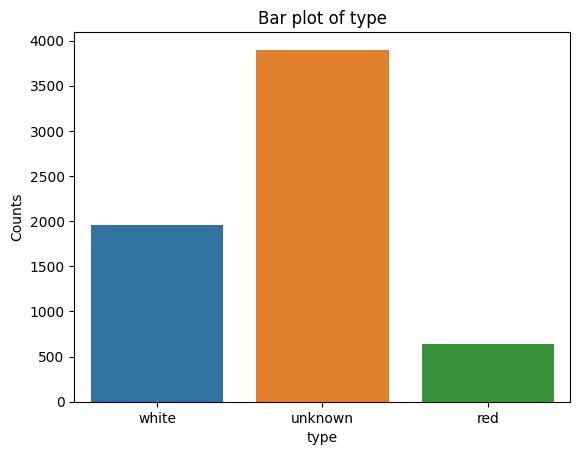

In [ ]:
sns.countplot(x="type",data=df,hue="type")
plt.title("Bar plot of type")
plt.xlabel("type")
plt.ylabel("Counts")
plt.show()

Σχόλιο:Απο το barplot της μεταβλητής Type αντλούμε την πληροφορία ότι τελικά τα δείγματα απο τα όποια λείπει το lebel Type είναι πολλά παραπάνω απο αυτά που το έχουν.

#Ερώτημα 2


In [ ]:
df["type"]=np.where(df["type"]=="white",0,np.where(df["type"]=="red",1,2))

In [ ]:
print(df["type"])

0       0
1       2
2       0
3       2
4       2
       ..
6492    1
6493    1
6494    2
6495    1
6496    1
Name: type, Length: 6497, dtype: int64


In [ ]:
x=df.drop(columns=["type"]).values
y=df["type"].values

#Ερώτημα 3

In [ ]:
mask_known = y != 2 #κραταμε οπυ το type ειναι 0 ή 1
mask_unknown = y == 2 # κρταμε οταν το type ειναι 2
x_known = x[mask_known]
y_known = y[mask_known]
x_unknown=x[mask_unknown]

In [ ]:
print(x_unknown)

[[ 6.3   0.3   0.34 ...  0.49  9.5   6.  ]
 [ 7.2   0.23  0.32 ...  0.4   9.9   6.  ]
 [ 7.2   0.23  0.32 ...  0.4   9.9   6.  ]
 ...
 [ 6.3   0.51  0.13 ...  0.75 11.    6.  ]
 [ 6.8   0.62  0.08 ...  0.82  9.5   6.  ]
 [ 6.3   0.51  0.13 ...  0.75 11.    6.  ]]


#Ερώτημα 4

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_known,y_known,test_size=0.2,random_state=42,stratify=y_known)

Σχόλιο: Χρησιμοποιύμε stratify=y_known έτσι ώστε ο διαμερισμός των δειγμάτων σε 70-30(train set,test set) να γίνει με τέτοιον τρόπο έτσι ώστε στο train set οι αναλογίες το κλάσεων 0,1 να διατηρούνται.


#Ερώτημα 5

In [ ]:
model=RandomForestClassifier(random_state=42)
model.fit(x_train,y_train)
y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)

#Train set
train_acc=accuracy_score(y_train,y_train_pred)
train_f1=f1_score(y_train,y_train_pred,average="weighted")
train_precision=precision_score(y_train,y_train_pred,average="weighted")
train_recall=recall_score(y_train,y_train_pred,average="weighted")

#Test set
test_acc=accuracy_score(y_test,y_test_pred)
test_f1=f1_score(y_test,y_test_pred,average="weighted")
test_precision=precision_score(y_test,y_test_pred,average="weighted")
test_recall=recall_score(y_test,y_test_pred,average="weighted")

print("Train set ")
print(f"Accuracy: {train_acc}")
print(f"F1 score: {train_f1}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print("\nTest set ")
print(f"Accuracy: {test_acc}")
print(f"F1 score: {test_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")

Train set 
Accuracy: 0.9995189995189995
F1 score: 0.9995188411404907
Precision: 0.9995193062795105
Recall: 0.9995189995189995

Test set 
Accuracy: 0.9980769230769231
F1 score: 0.998074377227618
Precision: 0.9980818164024271
Recall: 0.9980769230769231


Σχόλιο: Παρατηρούμε ότι όλες οι μετρικές που χρησιμοποιήσαμε δίνουν για το test test τιμές κοντά στο 1.Αυτό οφείλεται στο ότι κάναμε σωστό διαμερισμό των δεδομένων στο προηγούμενο ερώτημα,χρησιμοποιώντας stratify=y_known.Στην συγκεκριμένη περίπτωση παρόλο που όλες οι μετρικές δίνουν καλά κοντινά αποτελέσματα, η πιο αντιπροσωπευτική μετρική για το συγκεκριμένο dataset είναι η F1 score.Κάνουμε αυτήν την επιλογή γιατί οι δυο κλάσεις (0,1) δεν είναι ισοκατανεμημένες και η F1 score λαμάνει υπόωη της τόσο την πλειονάζουσα όσο και τη λιγότερη αντιπροσωπευτική κλάση,προσφέροντας έτσι μια πιο "δίκαιη" αξιολόγηση του μοντέλου.

#Ερώτημα 6


In [ ]:
model=RandomForestClassifier(random_state=42,class_weight="balanced")

Σχόλιο:Ορίζοντας στο ταξινομιτή RandomForestClassifier την παράμετρο class_weight="balanced" αυτό που πετυχαίνουμε είναι να αλλάξουμε τα βάρη των κλάσεων.Συγκεκριμένα η επιλογή αυτη προσαρμόζει τα βάρη κάθε κλάσεις ανάλογα με τον αριθμό των δειγμάτων της,δίνοντας μεγαλύτερο βάρος στις λιγότερο αντιπροσωπευτικές κλάσεις ώστε το μοντέλο να μην τις αγνοεί.Χρησιμοποιεί τις τιμές του y (y_known στην συγκεκριμένη περίπτωση) για να ρυθμίσει τα βάρη αντιστρόφως ανάλογα με τις συχνότητες των κλάσεων στα δεδομένα εισόδου ως εξής:

n_samples / (n_classes * nj)

όπου:

n_samples=συνολικός αριθμός των δειγμάτων

n_classes= αριθμός των κλάσεων

nj=ο αριθμός των δειγμάτων στην j κλάση



In [ ]:
model.fit(x_train,y_train)
y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)

#Train set
train_acc=accuracy_score(y_train,y_train_pred)
train_f1=f1_score(y_train,y_train_pred,average="weighted")
train_precision=precision_score(y_train,y_train_pred,average="weighted")
train_recall=recall_score(y_train,y_train_pred,average="weighted")

#Test set
test_acc=accuracy_score(y_test,y_test_pred)
test_f1=f1_score(y_test,y_test_pred,average="weighted")
test_precision=precision_score(y_test,y_test_pred,average="weighted")
test_recall=recall_score(y_test,y_test_pred,average="weighted")

print("Train set ")
print(f"Accuracy: {train_acc}")
print(f"F1 score: {train_f1}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print("\nTest set ")
print(f"Accuracy: {test_acc}")
print(f"F1 score: {test_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")

Train set 
Accuracy: 0.9995189995189995
F1 score: 0.9995191573898182
Precision: 0.9995199371417695
Recall: 0.9995189995189995

Test set 
Accuracy: 0.9980769230769231
F1 score: 0.998074377227618
Precision: 0.9980818164024271
Recall: 0.9980769230769231


#Ερώτημα 7

In [ ]:
y_unknown_proba=model.predict_proba(x_unknown)
print(y_unknown_proba)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


#Ερώτημα 8

In [ ]:
red_proba=y_unknown_proba[:,1]
y_unknown_numeric=np.where(red_proba>0.65,1,np.where(red_proba<0.35,0,2))
mask_known=y_unknown_numeric !=2
mask_unknown=y_unknown_numeric ==2
x_new_unknown=x_unknown[mask_unknown]
x_unknown=x_unknown[mask_known]
y_unknown=y_unknown_numeric[mask_known]


In [ ]:
print(len(x_new_unknown))

46


In [ ]:
print(y_unknown)

[0 0 0 ... 1 1 1]


#Ερώτημα 9


In [ ]:
x_train=np.vstack((x_known,x_unknown))
y_train=np.hstack((y_known,y_unknown))

In [ ]:
model=RandomForestClassifier(random_state=42,class_weight="balanced")
model.fit(x_train,y_train)
y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)

train_accuracy=accuracy_score(y_train,y_train_pred)
test_accuracy=accuracy_score(y_test,y_test_pred)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.999844985273601
Test Accuracy: 1.0


#Ερώτημα 10

In [ ]:
y_unknown_proba=model.predict_proba(x_new_unknown)

In [ ]:
red_proba=y_unknown_proba[:,1]
y_unknown_numeric=np.where(red_proba>0.65,1,np.where(red_proba<0.35,0,2))
mask_known=y_unknown_numeric !=2
mask_unknown=y_unknown_numeric ==2
x_unknown=x_new_unknown[mask_known]
y_unknown=y_unknown_numeric[mask_known]
x_new_unknown=x_new_unknown[mask_unknown]

In [ ]:
print(len(x_new_unknown))


30


In [ ]:
while len(x_new_unknown)>11:
  x_train=np.vstack((x_known,x_unknown))
  y_train=np.hstack((y_known,y_unknown))
  model.fit(x_train,y_train)
  y_unknown_proba=model.predict_proba(x_new_unknown)

  red_proba=y_unknown_proba[:,1]
  y_unknown_numeric=np.where(red_proba>0.65,1,np.where(red_proba<0.35,0,2))
  mask_known=y_unknown_numeric !=2
  mask_unknown=y_unknown_numeric ==2
  x_unknown=x_new_unknown[mask_known]
  y_unknown=y_unknown_numeric[mask_known]
  x_new_unknown=x_new_unknown[mask_unknown]

In [ ]:
print(len(x_new_unknown))

11


In [ ]:
x_train=np.vstack((x_known,x_unknown))
y_train=np.hstack((y_known,y_unknown))
model=RandomForestClassifier(random_state=42,class_weight="balanced")
model.fit(x_train,y_train)
y_unknown_proba=model.predict_proba(x_new_unknown)

red_proba=y_unknown_proba[:,1]
y_unknown_numeric=np.where(red_proba>0.65,1,np.where(red_proba<0.35,0,2))
mask_known=y_unknown_numeric !=2
mask_unknown=y_unknown_numeric ==2
x_unknown=x_new_unknown[mask_known]
y_unknown=y_unknown_numeric[mask_known]
x_new_unknown=x_new_unknown[mask_unknown]

In [ ]:
print(len(x_new_unknown))

11


Σχόλιο:Σε αυτό το σημείο παρατηρούμε ότι το μοντέλο να πρόβλεψει και να δώσει την πιθανότητα για το αν είναι άσπρο ή κόκκινο τα unknown δείγματα με βάση τους περιορισμούς που δώσαμε για τις πιθανότητες.

#Μέρος 2ο


#Ερώτημα 1

In [ ]:
df=pd.read_csv("wine-full.csv")

In [ ]:
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6487.000000       6489.000000  6494.000000     6495.000000   
mean        7.216579          0.339691     0.318722        5.444326   
std         1.296750          0.164649     0.145265        4.758125   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6495.000000          6497.000000           6497.000000  6497.000000   
mean      0.056042            30.525319            115.744574     0.994697   
std       0.035036            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

In [ ]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


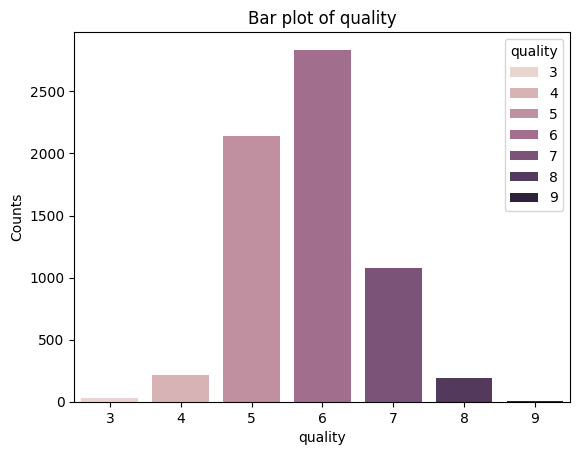

In [ ]:
sns.countplot(x="quality",data=df,hue="quality")
plt.title("Bar plot of quality")
plt.xlabel("quality")
plt.ylabel("Counts")
plt.show()

Σχόλιο:

Απο το barplot του χαρακτηριστικού quality φαίνεται ότι:
* Τα περισσότερα δείγματα παίρνουν τις τιμες 5,6,7
* Ενώ οι ακραίες τιμές 3,4,8,9 εμφανίζονται πιο σπάνια

Συνεπώς το σύνολο δεδομένων δεν είναι ισσοροπημένο ως προς την μεταβλητή quality καθώς υπάρχει μεγάλη ανισσοροπία στον αριθμό των δειγμάτων ανα κατηγορία ποιότητας.



#Ερώτημα 2

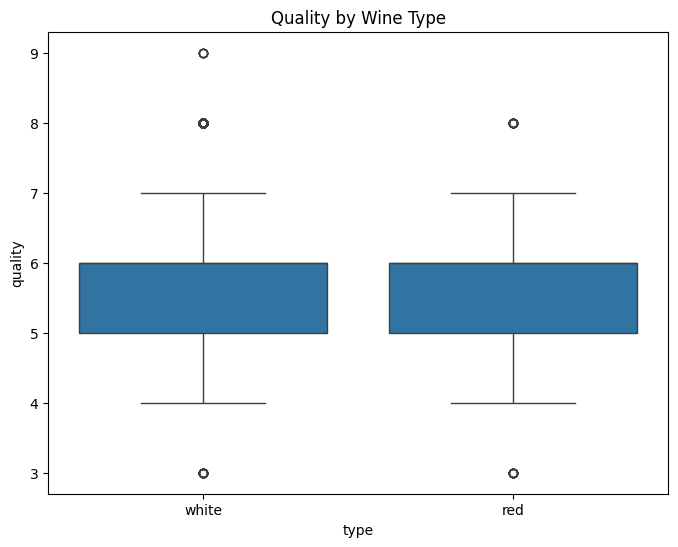

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x="type", y="quality", data=df)
plt.title("Quality by Wine Type")
plt.show()

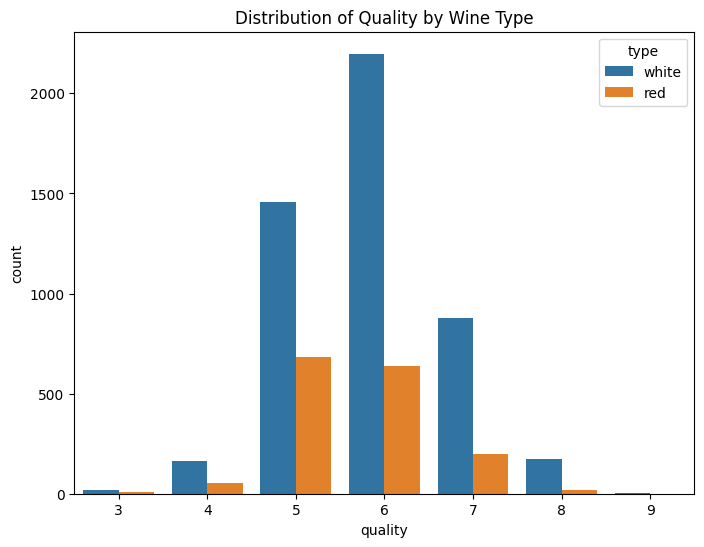

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x="quality", hue="type", data=df)
plt.title("Distribution of Quality by Wine Type")
plt.show()

In [ ]:
means = df.groupby("type")["quality"].mean()
print(means)

type
red      5.636023
white    5.877909
Name: quality, dtype: float64


Σχόλιο:

*   Το barplot για την ποιότητα τον κρασιώνν ανάμεσα στα δυο είδη, δεν μας δίνει ένα ξεκάθαρο αποτέλεσμα για το ποιο είδος είναι καλύτερο.
* Στην περίπτωση του histogram έχουμε μια πιο ξεκάθαρη εικόνα για την προτίμηση ανάμεσα στα δύο είδη.

Παρόλο που και τα δύο είδη έχουν καλή ποιότητα βλέπουμε ότι τα περισσότερα δείγματα είναι για λευκά κρασιά.Συνεπώς, με βάση το σύνολο δεδομένων που έχουμε τα λευκά κρασιά είναι η καλύτερη επιλογή.



#Ερώτημα 3


In [ ]:
mask_sweet=df["residual sugar"]>12
mask_dry=df["residual sugar"]<4
df_sweet=df[mask_sweet]
df_dry=df[mask_dry]

Σχόλιο:Σε αυτο το σημείο έχει γίνει ένας δισχωρισμός σε ξηρά και γλύκα κρασίά με βάση τις σύνηθες τιμές που μπορεί να πάρει κάθε κατηγορία.

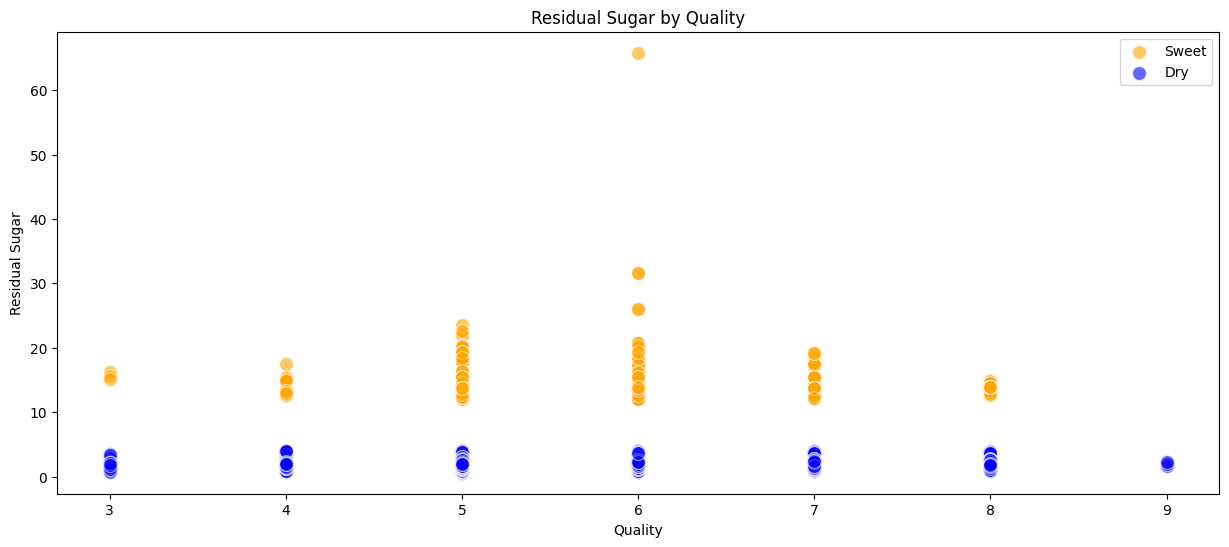

In [ ]:
plt.figure(figsize=(15,6))

sns.scatterplot(x="quality", y="residual sugar", data=df_sweet, color="orange", label="Sweet", s=100, alpha=0.6)

sns.scatterplot(x="quality", y="residual sugar", data=df_dry, color="blue", label="Dry", s=100, alpha=0.6)

plt.title("Residual Sugar by Quality")
plt.xlabel("Quality")
plt.ylabel("Residual Sugar")
plt.legend()
plt.show()

Σχόλιο:Βλέποντας το scatterplot παρατηρούμε ότι δεν υπάρχει μεγάλη συσχέτιση ανάμεσα στα γλυκά-ξηρά κρασιά και την ποιότητα,γιατί για παράδειγμα υπάρχουν αρκετά γλυκα κρασιά που έχουν ποιότητα μεγαλύτερη ή ίση με το 5.Παρόλα αυτά παρατηρούμε ότι μόνο η κατηγορία ξηρό κρασή φτάνει να έχει ποιότητα ίση με 9.Συνεπώς,με βάση το σύνολο δεδομένω αν χρειαζόταν να επιλέξουμε θα διαλέγαμε το ξηρο κρασί.

#Ερώτημα 4

In [ ]:
df["type"]=np.where(df["type"]=="white",0,np.where(df["type"]=="red",1,2))

In [ ]:
x=df.drop("quality",axis=1).values
y=df["quality"].values

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.10,random_state=0)

#Ερώτημα 5

In [ ]:
model=DecisionTreeRegressor(random_state=0)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
mae=mean_absolute_error(y_test,y_pred)

In [ ]:
print("mae=",mae)

mae= 0.44769230769230767


#Ερώτημα 6

In [ ]:
mae_list=[]
for i in range(10):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.10,random_state=i)
  model=DecisionTreeRegressor(random_state=0)
  model.fit(x_train,y_train)
  y_pred=model.predict(x_test)
  mae=mean_absolute_error(y_test,y_pred)
  mae_list.append(mae)


In [ ]:
mae_mean=np.mean(mae_list)
mae_std=np.std(mae_list)
print("mae_mean=",mae_mean)
print("mae_std=",mae_std)

mae_mean= 0.4661538461538462
mae_std= 0.026832815729997475


Σχόλιο: Η αξιλόγηση του μοντέλου DecsionTreeRegressor με 10 διαφορετικά seeds έδειξε ότι το μέσο σφάμλμα ΜΑΕ στο test set είναι περίπυ στο 0.47, με πολύ μικρή τυπική απόκληση 0.027.Δεδομένου ότι η ποιότητα κυμαίνεται 0 εως 10,το ΜΑΕ αντιστοιχεί σε μικρή απόκληση(π.χ. αν η πραγματική ποιότητα είναι 6,το μοντέλο συνήθως μπορεί να προβλέψει 5.5-6.5),υποδηλώντας ότι οι προβέψεις του μοντέλου είναι αξιόπιστες.Επιπλέον, η μικρή τυπική απόκλιση δείχνει ότι οι τυχαίες διαχωρίσεις των δεδομένων σε train/set δεν επηρεάζουν σημαντικά την απόδοση,καθιστώντας την εκτίμηση του αναμενόμενου σφάλματος σε νέα δεδομένα σταθερή.


#Ερώτημα 7

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=0)



In [ ]:
max_depth_options=[None,3,5,7,10]
min_samples_split_options=[2,5,10]
min_samples_leaf_options=[1,2]

In [ ]:

#δημιουργία όλων των συνδυασμών
all_combinations=list(itertools.product(max_depth_options,min_samples_split_options,min_samples_leaf_options))

In [ ]:
#επιλογή των προτων 15
combinations=all_combinations[:15]

In [ ]:
results=[]
for max_depth,min_samples_split,min_sample_leaf in combinations:
  model=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_sample_leaf,random_state=0)
  model.fit(x_train,y_train)
  y_val_pred=model.predict(x_val)
  y_tain_pred=model.predict(x_train)
  mae_val=mean_absolute_error(y_val,y_val_pred)
  mae_train=mean_absolute_error(y_train,y_tain_pred)
  results.append({"max_depth":max_depth,"min_samples_spli":min_samples_split,"min_samples_leaf":min_sample_leaf,"MAE_train":mae_train,"MAE_val":mae_val})

In [ ]:
results_df=pd.DataFrame(results)
print(results_df.sort_values("MAE_val"))

    max_depth  min_samples_spli  min_samples_leaf  MAE_train   MAE_val
0         NaN                 2                 1   0.000214  0.506838
2         NaN                 5                 1   0.064108  0.524074
4         NaN                10                 1   0.170017  0.526096
1         NaN                 2                 2   0.102829  0.530456
3         NaN                 5                 2   0.123997  0.530997
5         NaN                10                 2   0.217752  0.543364
13        5.0                 2                 2   0.545089  0.599628
12        5.0                 2                 1   0.545978  0.599920
14        5.0                 5                 1   0.545978  0.599920
6         3.0                 2                 1   0.584908  0.609461
7         3.0                 2                 2   0.584908  0.609461
8         3.0                 5                 1   0.584908  0.609461
11        3.0                10                 2   0.584908  0.609461
10    

In [ ]:
model=DecisionTreeRegressor(max_depth=None,min_samples_leaf=1,min_samples_split=2,random_state=0)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
test_mae=mean_absolute_error(y_test,y_pred)
print("Test MAE:",test_mae)


Test MAE: 0.5046153846153846


#Ερώτημα 8

Για την επιλογή υπερπαραμέτρων είναι καλό να χρησιμοποιήσουμε  validation set, καθώς δεν συμμετέχει στην εκπαίδευση του μοντέλου και παρέχει μια αξιόπιστη εκτίμηση της ικανότητας γενίκευσης.Το training set δεν είναι κατάλληλο,επείδη το σφάλμα του μπορεί να είναι πολύ μικρό λόγω overfiting στα δεδομένα εκπαίδευσης.

#Ερώτημα 9

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.10,random_state=0)

In [ ]:
mae_scorer=make_scorer(mean_absolute_error,greater_is_better=False)
param_grid={"max_depth":[None,3,5,7,10],"min_samples_split":[2,5,10],"min_samples_leaf":[1,2]}


In [ ]:
grid=GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),param_grid=param_grid,cv=10,scoring=mae_scorer,n_jobs=-1)
grid.fit(x_train,y_train)


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 7, 10],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'))

#Ερώτημα 10

In [ ]:
print("Οι καλύτεροι παράμετροι είναι:")
print(grid.best_params_)

Οι καλύτεροι παράμετροι είναι:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
model=DecisionTreeRegressor(max_depth=None,min_samples_leaf=1,min_samples_split=2,random_state=0)
model.fit(x_train,y_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
y_pred=model.predict(x_test)
test_mae=mean_absolute_error(y_test,y_pred)
print("Test MAE:",test_mae)

Test MAE: 0.44769230769230767


Σχόλιο:
*   Στο ερώτημα 6 παρόλο που εκπαιδεύσαμε το μοντελό χρησιμοποιώντας κάθε φορά διαφορετικό random_state στο split των traing set και test set,ο μέσος όρος όλων των τελικών σφαλμάτων ΜΑΕ που παράχθηκαν δεν ήταν μικρότερος από ότι ήταν το σφάλμα ΜΑΕ στο ερώτημα 7.Αυτό σημβαίνει γιατί στο ερώτημα 7 κάναμε μια διερεύνηση για την εύρεση καλύτερων υπερπαραμέτρων χρησιμοποιώντας το validation set και στην συνέχεια με το καλύτερο σετ κάναμε πρόβλεψη.
*  Στο ερώτημα 7 κάναμε έρευνα ανάμεσα σε 15 σετ απο υπερπαραμέτρους
έχωντας χρησιμοποιήση ένα training set και ένα validation set.Στο ερώτημα 9 εφαρμόσαμε GridSearchCV με 10-fold cross-validation.Και στις δυο περιπτώσεις προέκυψε το ίδιο καλύτερο σετ υπερπαρπαραμέτρων, όμως στο ερώτημα 9 το τελικό σφάλμα ΜΑΕ στο test set ήταν μικρότερο.Αυτό οφείλεται στο ότι η διαδικασία crooss-validation δημιοργεί περισσότερα spplits και επιτρέπει στο μοντέλο να εκπαιδευτεί σε μεγαλύτερο όγκο δεδομένων,οδηγώντασ σε πιο σταθερό και αξιόπιστο αποτέλεσμα.



#Ερώτημα 11


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.10,random_state=0)

In [ ]:
mae_scorer=make_scorer(mean_absolute_error,greater_is_better=False)
param_grid={"max_depth":[5],"min_samples_split":[2,5,10],"min_samples_leaf":[1,2]}


In [ ]:
grid=GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),param_grid=param_grid,cv=10,scoring=mae_scorer,n_jobs=-1)
grid.fit(x_train,y_train)


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'))

In [ ]:
print("Οι καλύτεροι παράμετροι είναι:")
print(grid.best_params_)

Οι καλύτεροι παράμετροι είναι:
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
model=DecisionTreeRegressor(max_depth=5,min_samples_leaf=1,min_samples_split=2,random_state=0)
model.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [ ]:
y_pred=model.predict(x_test)
test_mae=mean_absolute_error(y_test,y_pred)
print("Test MAE:",test_mae)

Test MAE: 0.5534852696756091


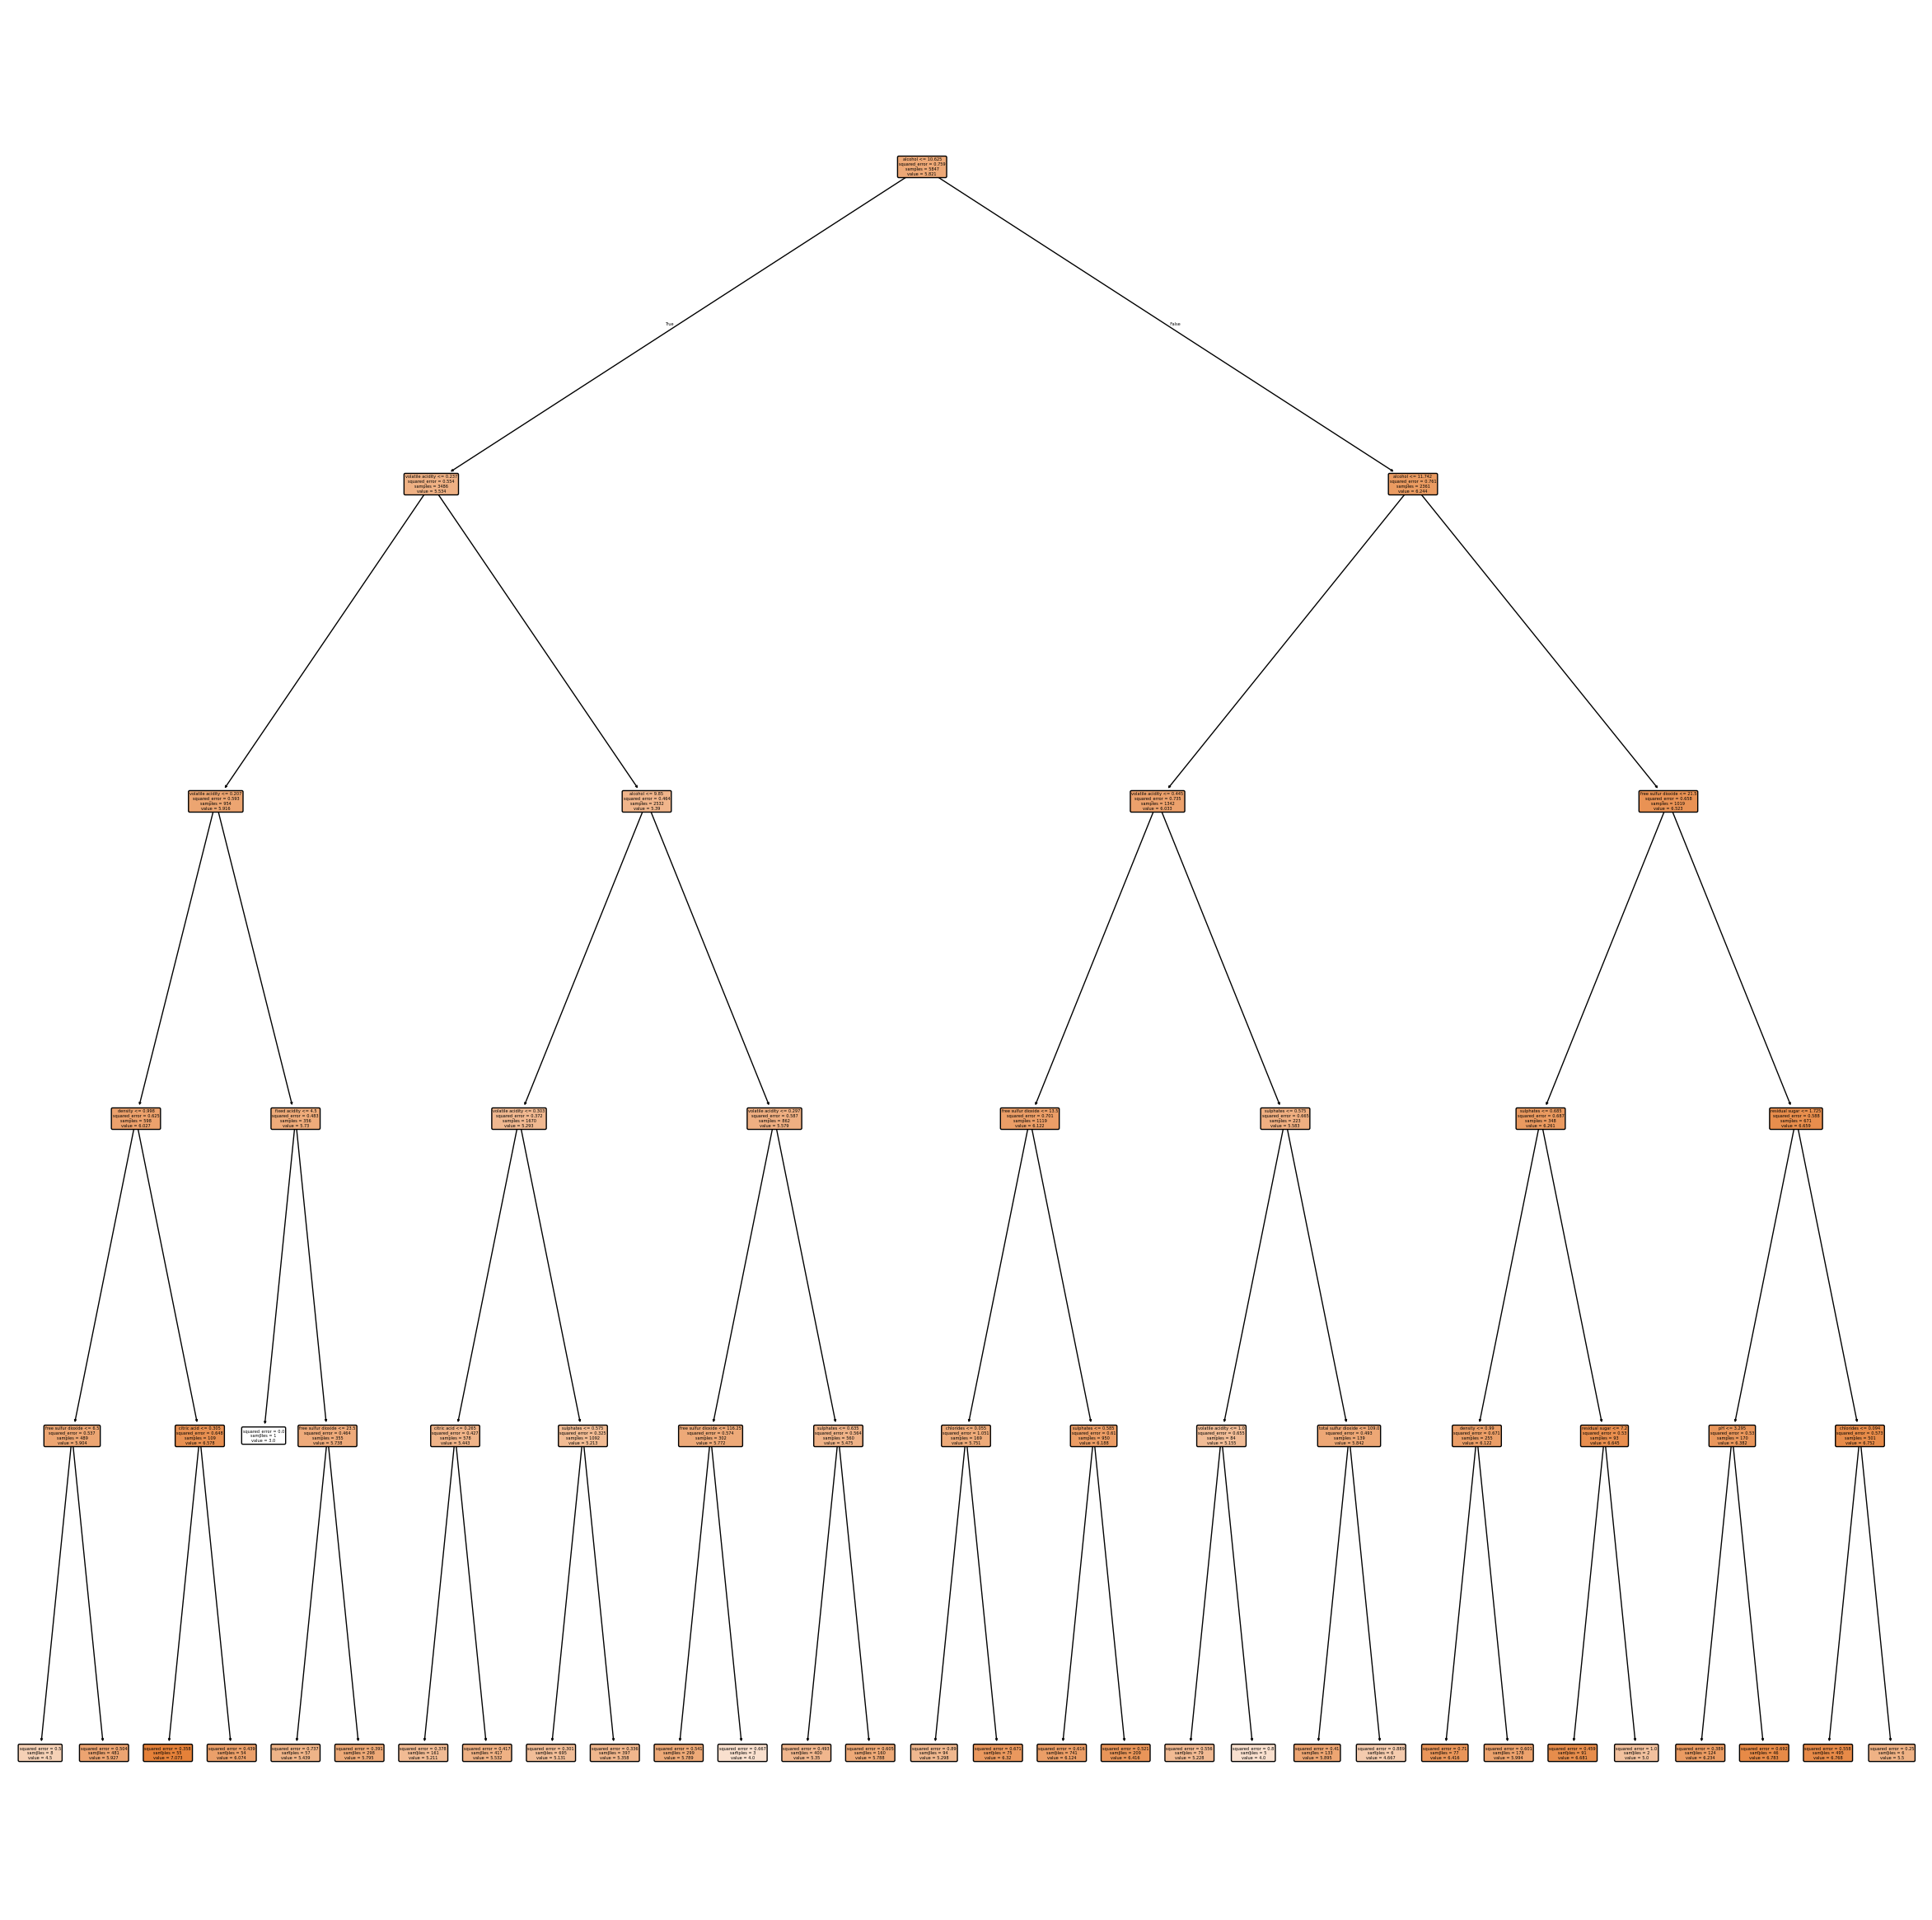

In [ ]:
plt.figure(figsize=(30,30))
plot_tree(model,feature_names=df.drop("quality",axis=1).columns,filled=True,rounded=True)
plt.show()

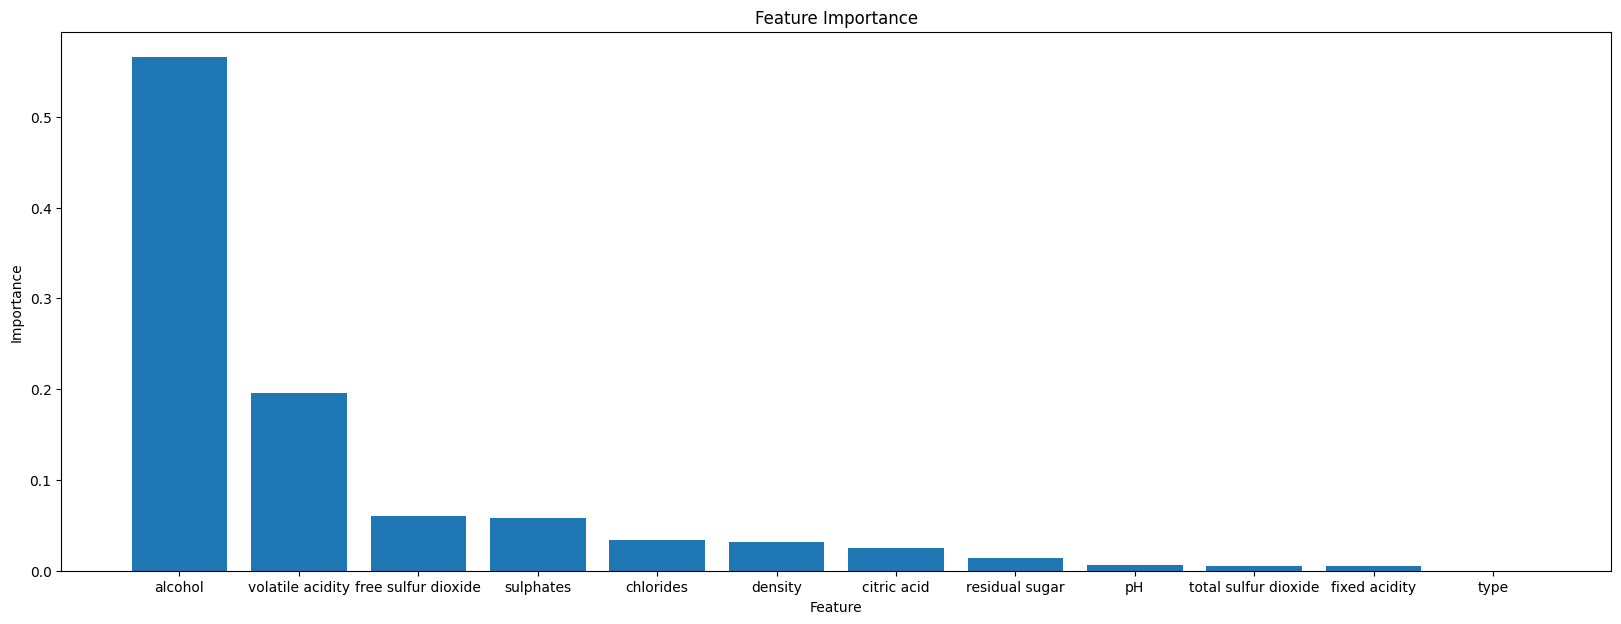

In [ ]:
features=df.drop("quality",axis=1).columns
importances=model.feature_importances_
features_importances=pd.DataFrame({"Feature":features,"Importance":importances})
features_importances=features_importances.sort_values("Importance",ascending=False)

plt.figure(figsize=(20,7))
plt.bar(features_importances["Feature"],features_importances["Importance"])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()